Notebook purpose

- Explore entropy scores

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import s3fs

sys.path.append('/Users/fgu/dev/projects/entropy')
from entropy import config

import entropy.helpers.aws as ha
import entropy.helpers.helpers as hh 
import entropy.helpers.data as hd
import entropy.data.cleaners as cl
import entropy.data.creators as cr
import entropy.figures.figures as figs

sns.set_style('whitegrid')
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)
pd.set_option('max_colwidth', None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

fs = s3fs.S3FileSystem(profile='3di')

In [2]:
dfs, df = hd.load_samples(['777', 'XX7'])
hd.inspect(df)

Time for read_data      : 2.40 seconds
Time for read_data      : 6.62 minutes
(6,791,894, 32)


,id,date,user_id,amount,desc,merchant,tag_group,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,updated_flag,ym,savings,balance,income,entropy_tag
0,19510816,2014-03-07,107,9.20,paypal sandrpowell 9001,paypal,spend,services,0.0,gl3 4,2010-05-10,40k to 50k,1984.0,2014-05-11,238820,2020-08-16 12:13:00,barclaycard,credit card,2014-07-18,2017-09-12,True,NaN,paypal,enjoyment,home electronics,home electronics,u,201403,0.0,NaN,27530.926758,3.019948
1,19510817,2014-03-08,107,6.94,paypal smartbitsso 9001,paypal,spend,services,0.0,gl3 4,2010-05-10,40k to 50k,1984.0,2014-05-11,238820,2020-08-16 12:13:00,barclaycard,credit card,2014-07-18,2017-09-12,True,NaN,paypal,enjoyment,home electronics,home electronics,u,201403,0.0,NaN,27530.926758,3.019948


# Cross-sectional entropy

## Overview

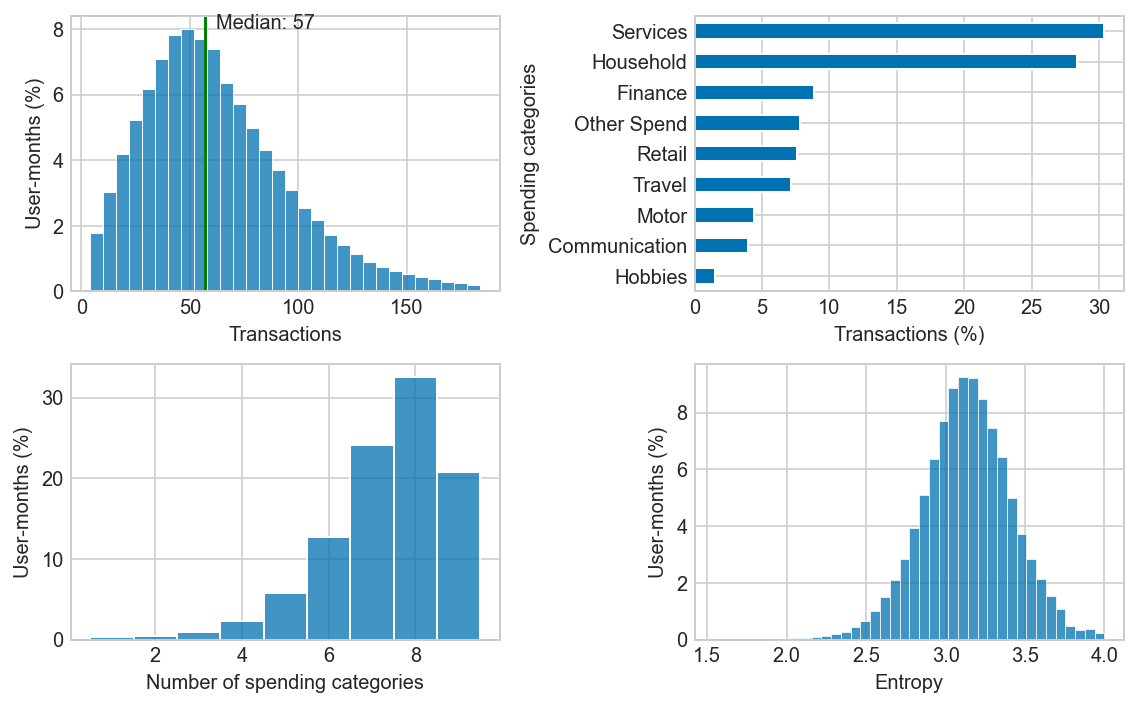

In [23]:
data = df
write = False

figs.txns_breakdowns_and_entropy(data, write=write)

## Case studies

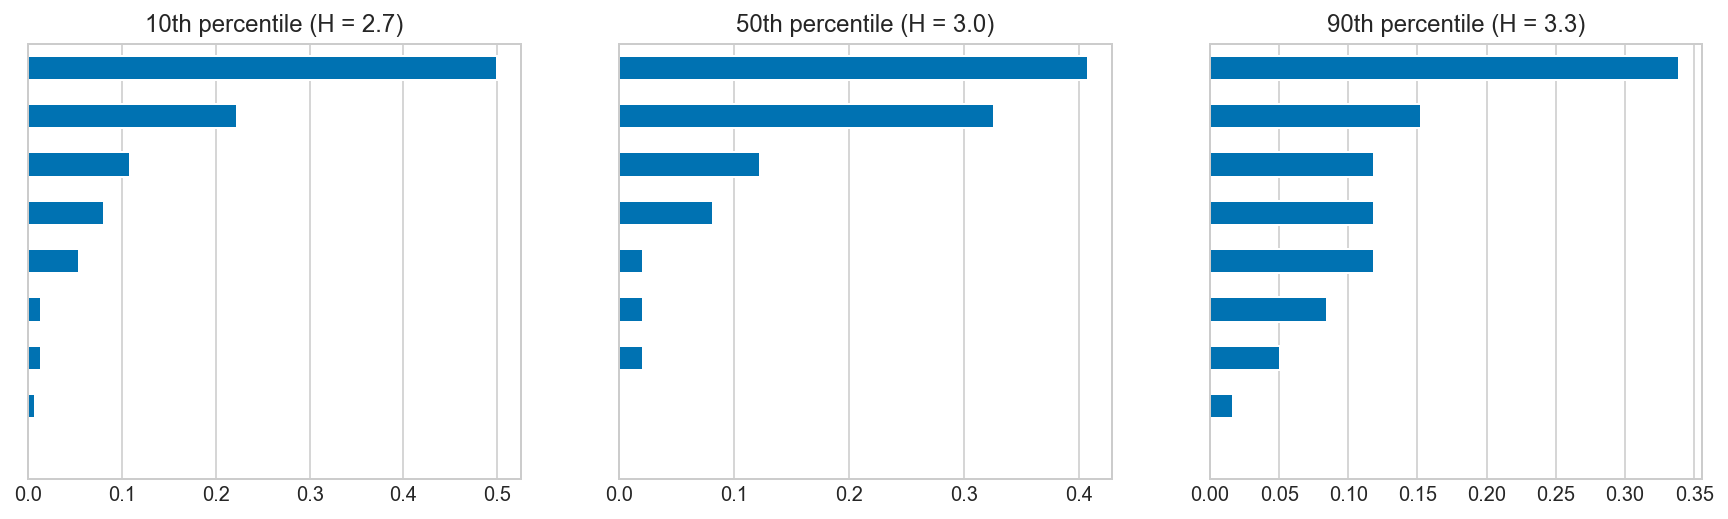

In [24]:
def make_spend_data(df):
    """Retains only spending transactions."""
    df = df[df.tag_group.eq('spend')].copy()
    df['tag'] = df.tag.cat.remove_unused_categories()
    return df

def entropy_pct_case_study(df, pct):
    """Returns first user-month with entropy score at specified percentile."""
    pct_val = np.nanpercentile(df.entropy_tag, pct)
    pct_data = df[df.entropy_tag.eq(pct_val)]
    pct_data = pct_data.set_index(['ym', 'user_id'])
    first_user_month = pct_data.index.unique()[0]
    return pct_data.loc[first_user_month].reset_index()
    
def spend_breakdown(df, ax=None):
    """Plots breakdown of spending transactions across tags."""
    spend = df[df.tag_group.eq('spend')].copy()
    spend.tag.value_counts(ascending=True, normalize=True).plot(kind='barh', yticks=None, ax=ax)
    
def entropy_pct_case_studies(df, percentiles=None, **kwargs):
    """Shows spend txns breakdown for entropy percentiles sample users."""
    if percentiles is None:
        percentiles = [10, 50, 90]
    num_plots = len(percentiles)
    spend_data = make_spend_data(df)
    fig, ax = plt.subplots(1, num_plots, **kwargs)
    for i, pct in enumerate(percentiles):
        data = entropy_pct_case_study(spend_data, pct)
        entropy = data.entropy_tag[0]
        title = f'{pct}th percentile (H = {entropy:.1f})'
        spend_breakdown(data, ax=ax[i])
        ax[i].set(title=title)
        ax[i].get_yaxis().set_ticks([])
    return fig, ax

entropy_pct_case_studies(df, figsize=(15, 4));

## By year

We'd expect the cross-sectional distribution for different years to look very similar. The below figure confirms this.

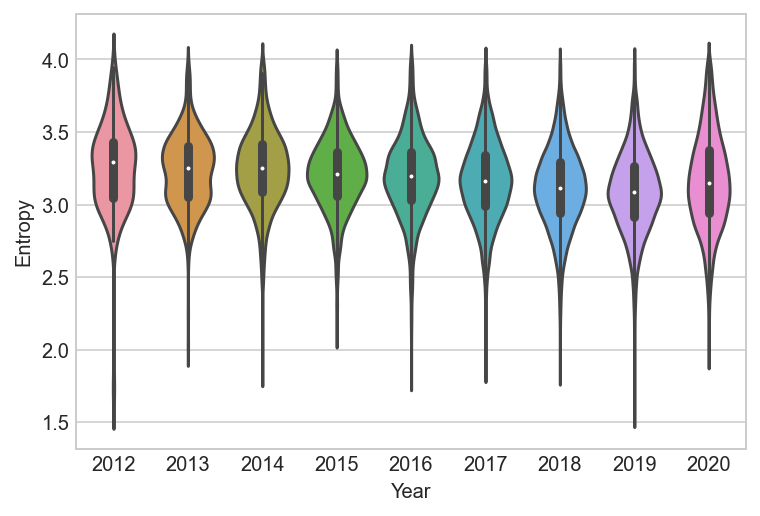

In [74]:
def make_data(df):
    return df.groupby([df.date.dt.year, 'user_id', 'ym']).entropy_tag.first().reset_index()

def make_figure(data):
    fig, ax = plt.subplots()
    sns.violinplot(data=data, ax=ax, x='date', y='entropy_tag')
    ax.set(xlabel='Year', ylabel='Entropy')
    
data = make_data(df)
make_figure(data)

# Entropy over time

## Within user variation

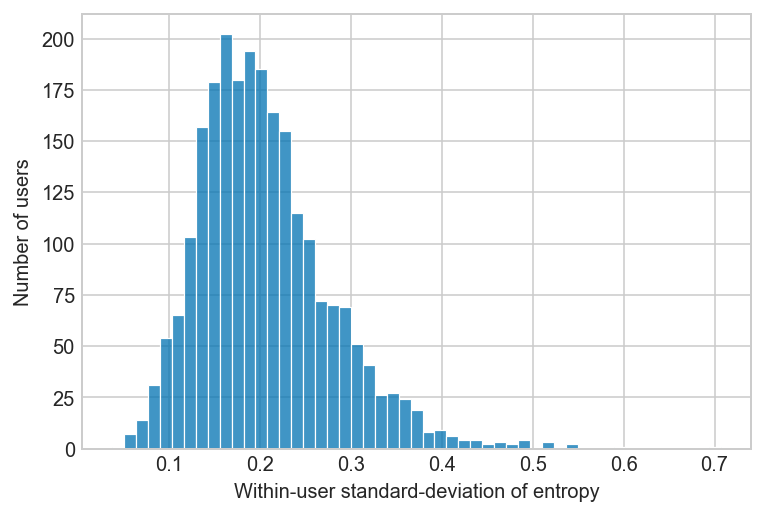

In [82]:
def make_data(df):
    return df.groupby(['user_id', 'ym']).entropy_tag.first().groupby(['user_id']).std().reset_index()

def make_figure(data):
    fig, ax = plt.subplots()
    sns.histplot(data=data, ax=ax,x='entropy_tag')
    ax.set(ylabel='Number of users', xlabel='Within-user standard-deviation of entropy')
    
data = make_data(df)
make_figure(data)